In [1]:
import gym

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import time
import random

import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

In [2]:
env = gym.make('InvertedPendulum-v2')

print('Number of observation:', env.observation_space.shape, '\n number of actions:', env.action_space)
# for _ in range(100):
#     env.render()
#     time.sleep(0.01)
#     env.step(env.action_space.sample())   # take random actions  

Number of observation: (4,) 
 number of actions: Box(1,)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
N_EPISODES = 2000
DISCOUNT = 0.99

OBS_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]


In [5]:
mean_avg = []
def plot(n_rewards):
    clear_output(True)
    plt.figure(figsize=(20,7))
    mean = np.mean(n_rewards[-10:])
#     plt.subplot(131)
    mean_avg.append(mean)
    plt.title('Reward: %s' % (mean))
    plt.plot(n_rewards)
    plt.plot(mean_avg)
#   plt.subplot(132)
#   plt.title('loss')
#   plt.plot(losses)
    plt.show()

In [6]:
class mcpg(nn.Module):
    def __init__(self, observations, actions):
        super(mcpg, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(observations, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, actions)
        )
    
    def forward(self, x):
        return self.network(x)

In [7]:
def act(state, std = 0.0):
#     global START_EPS, EPS_DECAY, END_EPS
#     START_EPS = max((START_EPS*EPS_DECAY), END_EPS)
    
    log_std = nn.Parameter(torch.ones(1, ACTION_DIM) * std)
    
    state = torch.FloatTensor(state).to(device)

    prob = policy(state)
    prob = prob.unsqueeze(dim = 0)
    
    std   = log_std.exp().expand_as(prob).to(device)
    
    m = torch.distributions.Normal(prob, std)
    action = m.sample()
    log_prob = m.log_prob(action)
    
#     print(log_prob.item())
    
    return action.detach().cpu().numpy(), log_prob

In [8]:
policy = mcpg(OBS_DIM, ACTION_DIM).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)


In [9]:
class Return_Buffer():
    def __init__(self, DISCOUNT):
        self.log_probs = []
        self.returns = []
        self.discount = DISCOUNT
        
    def clear(self):
        self.log_probs = []
        self.returns = []
        
    def push(self, log_prob, rewards):
        r = rewards.copy()
        discounts = [self.discount**i for i in range(len(r))]
        
        Gt = [np.sum(np.multiply(r[i:], discounts[:len(r)-i])) for i in range(len(r))]
        
        
        self.log_probs.append(log_prob)
#         print(self.log_probs)
        self.returns.append(Gt)
        
#         print(self.log_probs)
#         print(self.returns)

In [10]:
trajectory = Return_Buffer(DISCOUNT)

In [11]:
def update():
    optimizer.zero_grad()
    loss = 0
#     print(trajectory.log_probs[0])
#     print(trajectory.returns)
    for itr, log_prob in enumerate(trajectory.log_probs[0]):
        ret = trajectory.returns[0][itr]
#         print(log_prob*ret)
#         print(torch.sum(log_prob*ret))
        
        loss -= torch.sum(log_prob*ret)
        
    loss.backward()
    optimizer.step()
    
    trajectory.clear()        

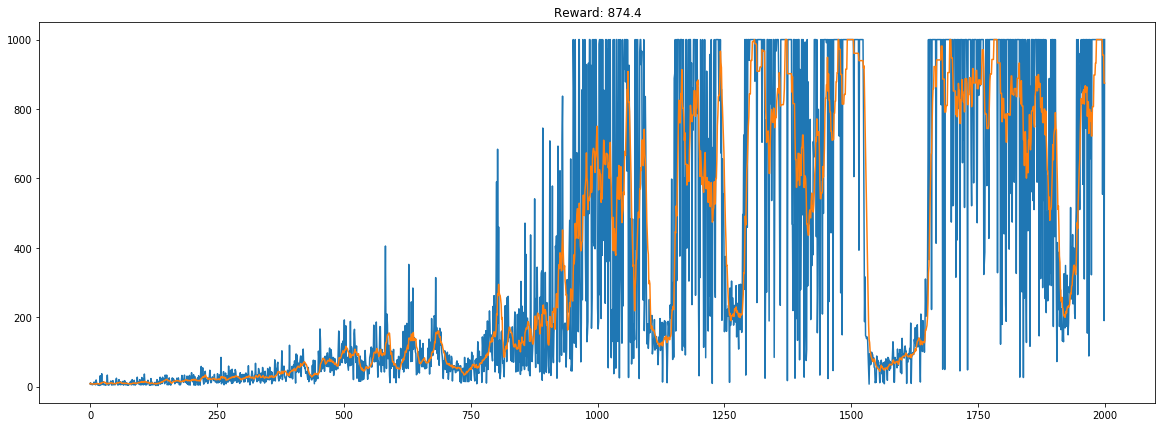

In [12]:
n_rewards = []

for i in range(1, N_EPISODES+1):
    ep_rewards = []
    log_probs = []
    total_reward = 0
    done = False
    
    state = env.reset()
    
    while not done:
        action, log_prob = act(state)
        
        next_state, reward, done, _ = env.step(action)
        
        ep_rewards.append(reward)
        log_probs.append(log_prob)
        total_reward += reward
#         if i%5 == 0:
#             env.render()
        state = next_state
    
    trajectory.push(log_probs, ep_rewards)
    
    update()
    n_rewards.append(total_reward)
    plot(n_rewards)
    
    if np.mean(n_rewards[-10:]) == 1000:
        torch.save(policy.state_dict(), 'Reinforce.pth')
        print("Model Saved")

In [13]:
state = env.reset()
total_reward = 0
done = False

policy.load_state_dict(torch.load('/home/himanshu/RL/Policy-based-RL/Reinforce.pth'))
print("Model Loaded")
policy.to(device)

while not done:
    action, log_prob = act(state)
    
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    
    env.render()
    time.sleep(0.01)
    
    state = next_state
    
print('Duration till which pole is balanced: ', total_reward)

env.close()

Model Loaded
Creating window glfw
Duration till which pole is balanced:  1000.0
